# Libraries, figure parameters and custom functions

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ann
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
#from gprofiler import gprofiler
import os
#import custom_functions as cf 
from sklearn.linear_model import LinearRegression

Add date.

In [2]:
from datetime import date

In [3]:
today = date.today().strftime("%y%m%d")

Add my color scheme.

In [4]:
colors2 = plt.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

Set parameters for plots in scanpy

In [5]:
sc.settings.set_figure_params(dpi=80)

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map='viridis', format='pdf', transparent=False,
                     ipython_format='png2x')

In [6]:
def cell_compo_table(adata, cluster, condition, xlabel='cell cluster',
                        ylabel='cell count', title=None, save=False):
    """
    """
    

    contingency_table = pd.crosstab(
        adata.obs[condition],
        adata.obs[cluster],
        margins = True
    )
    return(contingency_table)

def top_marker_as_xlsx(adata, key_rank_genes, key_groups, output_file):
    
    print(adata.uns[key_rank_genes].keys())
    dict_genes = adata.uns[key_rank_genes].copy()
    print(dict_genes['params'])
    del dict_genes['params']
    clusters = sorted(list(set(adata.obs[key_groups])))*len(dict_genes['scores'])
    for key, value in dict_genes.items():
        tmp_list = []
        for n in value:
            tmp_list = tmp_list + list(n)
        dict_genes[key] = tmp_list
    
    dict_genes['cluster'] = clusters

    dataframe = pd.DataFrame(dict_genes)
    dataframe.to_excel(output_file)
    return(dataframe)

# Load data

In [7]:
project_dir = '/storage/groups/ml01/workspace/maren.buettner/Martinez_Liver_HPC/'

In [8]:
data_dir = project_dir + 'data/'

In [9]:
adata_wt_young = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_cells_filtered_TPM_mar21_annotated.h5ad')
adata_wt_old = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_cells_filtered_TPM_mar21_annotated.h5ad')

In [10]:
adata_young_HNF4 = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_HNF4-KO_filtered_TPM_mar21_annotated.h5ad')
adata_old_HNF4 = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_HNF4-KO_filtered_TPM_mar21_annotated.h5ad')
adata_young_CTCF = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_CTCF-KO_filtered_TPM_mar21_annotated.h5ad')
adata_old_CTCF = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_CTCF-KO_filtered_TPM_mar21_annotated.h5ad' )
adata_young_CEBPA = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_CEBPA-KO_filtered_TPM_mar21_annotated.h5ad')
adata_old_CEBPA = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_CEBPA-KO_filtered_TPM_mar21_annotated.h5ad')

We merge `adata_young` and `adata_old` in order to use the separately created cell type annotation.

In [11]:
adata_all = ann.concat([adata_wt_young, adata_wt_old, 
                        adata_young_HNF4, adata_old_HNF4,
                        adata_young_CTCF, adata_old_CTCF,
                        adata_young_CEBPA, adata_old_CEBPA,
                       ], index_unique=None)

In [12]:
adata_all.uns = adata_wt_young.uns
adata_all.varm = adata_wt_young.varm
adata_all.var['gene_name'] = adata_wt_young.var['gene_name']

Add covariate combining age and ploidy.

In [13]:
age_ploidy = [adata_all.obs['age_grouped'][idx] + ' ' + adata_all.obs['ploidy'][idx] for idx in range(adata_all.n_obs)]

In [14]:
adata_all.obs['age_ploidy'] = pd.Categorical(age_ploidy, categories=['young 2n', 'young 4n', 'old 2n', 'old 4n'])

Add strain information to the age and ploidy covariate.

In [15]:
strain_age_ploidy = [adata_all.obs['strain'][idx] + ' ' + 
                     adata_all.obs['age_grouped'][idx] + ' ' + 
                     adata_all.obs['ploidy'][idx] for idx in range(adata_all.n_obs)]

In [16]:
adata_all.obs['strain_age_ploidy'] = pd.Categorical(strain_age_ploidy, 
                                categories=['C57Bl6/J young 2n', 'C57Bl6/J young 4n', 
                                            'C57Bl6/J old 2n', 'C57Bl6/J old 4n',
                                            'HNF4 KO young 2n', 'HNF4 KO young 4n', 
                                            'HNF4 KO old 2n', 'HNF4 KO old 4n',
                                            'CEBPA KO young 2n', 'CEBPA KO young 4n', 
                                            'CEBPA KO old 2n', 'CEBPA KO old 4n',
                                            'CTCF KO young 2n', 'CTCF KO young 4n', 
                                            'CTCF KO old 2n', 'CTCF KO old 4n'
                                           ])

Add strain and age info as covariate.

In [17]:
strain_age = [adata_all.obs['strain'][idx] + ' ' + 
              adata_all.obs['age_grouped'][idx] for idx in range(adata_all.n_obs)]

In [18]:
adata_all.obs['strain_age'] = pd.Categorical(strain_age, 
                                categories=['C57Bl6/J young', 
                                            'C57Bl6/J old', 
                                            'HNF4 KO young', 
                                            'HNF4 KO old',
                                            'CEBPA KO young',
                                            'CEBPA KO old',
                                            'CTCF KO young',
                                            'CTCF KO old', 
                                           ])

Edit the raw object to use the gene symbols for plotting (e.g. in `stacked_violin` plot).

In [19]:
adata_all.raw.var['gene_name'] = adata_wt_young.var['gene_name']

Create a t-SNE plot to convert all metadata to categorical variables.

... storing 'exp.' as categorical
... storing 'strain' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'row' as categorical
... storing 'age_grouped' as categorical
... storing 'cyclone_phases' as categorical
... storing 'leiden_r1' as categorical
... storing 'leidenr02_02' as categorical


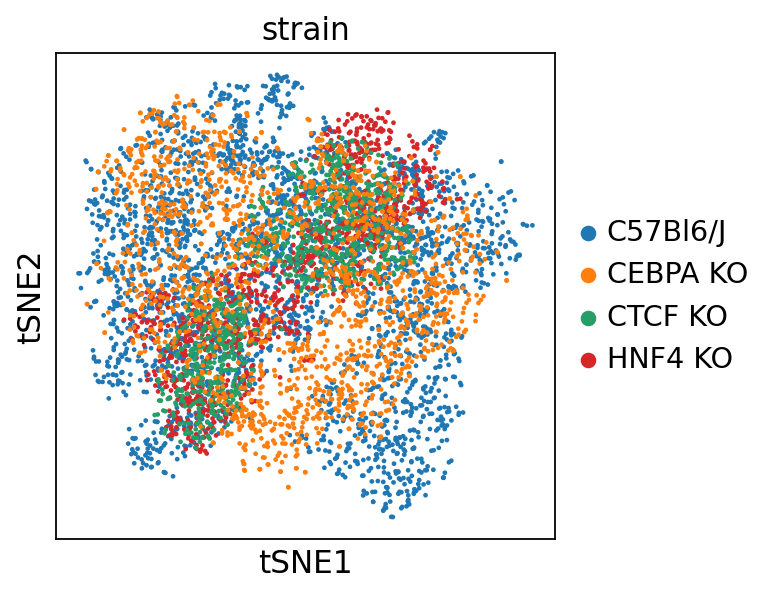

In [20]:
sc.pl.tsne(adata_all, color='strain')

# Introduction

In this notebook, we perform a set of advanced analyses of the hepatocyte population.

1. Variability analysis - Compute CV^2 (hepatocytes (all), then 2n and 4n), all other cell types) - young and old and per strain


Combine 'T cells',
       'Plasma B-cells', 'B cells' into 'lymphocytes'.

In [21]:
adata_all.obs['cell_type1'].cat.categories

Index(['Hepatocytes', 'Hepatobiliary cells', 'Endothelial cells',
       'Kupffer and Dendritic cells', 'Stellate cells', 'Plasma B-cells',
       'B cells', 'T cells'],
      dtype='object')

In [22]:
adata_all.obs['cell_type'].cat.categories

Index(['2n Hepatocytes', '4n Hepatocytes', 'Hepatobiliary cells',
       'Endothelial cells', 'Kupffer and Dendritic cells', 'T cells',
       'Plasma B-cells', 'B cells', 'Stellate cells'],
      dtype='object')

In [23]:
adata_all.obs['cell_type'] = adata_all.obs['cell_type'].cat.add_categories(['Lymphocytes'])
adata_all.obs['cell_type'][adata_all.obs['cell_type'].isin(['T cells',
       'Plasma B-cells', 'B cells'])] = 'Lymphocytes'
adata_all.obs['cell_type'] = adata_all.obs['cell_type'].cat.remove_unused_categories()

In [24]:
adata_all.obs['cell_type1'] = adata_all.obs['cell_type1'].cat.add_categories(['Lymphocytes'])
adata_all.obs['cell_type1'][adata_all.obs['cell_type1'].isin(['T cells',
       'Plasma B-cells', 'B cells'])] = 'Lymphocytes'
adata_all.obs['cell_type1'] = adata_all.obs['cell_type1'].cat.remove_unused_categories()

In [25]:
adata_all.obs['cell_type1'].cat.categories

Index(['Hepatocytes', 'Hepatobiliary cells', 'Endothelial cells',
       'Kupffer and Dendritic cells', 'Stellate cells', 'Lymphocytes'],
      dtype='object')

In [26]:
adata_all.obs['cell_type'].cat.categories

Index(['2n Hepatocytes', '4n Hepatocytes', 'Hepatobiliary cells',
       'Endothelial cells', 'Kupffer and Dendritic cells', 'Stellate cells',
       'Lymphocytes'],
      dtype='object')

Reorder categories such that lymphocytes are listed the second last. 

In [27]:
adata_all.obs['cell_type'] = adata_all.obs['cell_type'].cat.reorder_categories(['2n Hepatocytes',
                                                                                '4n Hepatocytes', 
                                                                                'Hepatobiliary cells',
       'Endothelial cells', 'Kupffer and Dendritic cells',
       'Lymphocytes', 'Stellate cells'])

In [28]:
adata_all.obs['cell_type1'] = adata_all.obs['cell_type1'].cat.reorder_categories(['Hepatocytes',
                                                                               
                                                                                'Hepatobiliary cells',
       'Endothelial cells', 'Kupffer and Dendritic cells',
       'Lymphocytes', 'Stellate cells'])

Select hepatocytes.

In [29]:
adata_hep = adata_all[adata_all.obs['cell_type1']=='Hepatocytes'].copy()

In [30]:
adata_hep

AnnData object with n_obs × n_vars = 3951 × 30520
    obs: 'batch', 'exp.', 'libraryID', 'experiment', 'strain', 'age', 'sex', 'ploidy', 'ERCC.dilution', 'column', 'row', 'percentERCC', 'n_counts', 'age_grouped', 'n_counts_raw', 'n_counts_transcripts', 'n_counts_ERCC', 'n_genes', 'high_ERCC', 'low_ERCC', 'low_genes', 'high_genes', 'low_counts', 'high_counts', 'ERCC_size_factor', 'n_counts_TPM', 'RPK_factor', 'n_counts_TPM_norm', 'mean_transcript_count_TPM', 'cyclone_phases', 'score_G1', 'score_S', 'score_G2M', 'leiden_r1', 'leiden_r02', 'low_res_ct', 'clusters', 'score_B cells', 'score_Dendritic cell', 'score_Lymphocyte', 'score_Natural killer', 'score_Neutrophil', 'score_Kupffer and Macrophage', 'score_Cholangiocyte', 'score_Endothelial', 'score_Hepatocyte', 'score_Hepatoblast', 'leidenr02_02', 'cell_type', 'hblast_marker_sum', 'cell_type1', 'age_ploidy', 'strain_age_ploidy', 'strain_age'
    var: 'gene_name'
    uns: 'ERCC.dilution_colors', 'clusters_colors', 'cyclone_phases_colors',

# Variability analysis

Threshold the genes: `mean(logTPM)>0.25`

In [31]:
adata_all.var['gene_mean'] = adata_all.X.mean(axis=0)

In [32]:
adata_cv = adata_all[:,adata_all.var['gene_mean']>0.25].copy()

In [33]:
adata_hep_cv = adata_hep[:,adata_all.var['gene_mean']>0.25].copy()

In [34]:
adata_cv.n_vars

1990

In [35]:
adata_all.obs['cell_type1'] = adata_all.obs['cell_type1'].astype('category')

Compute coefficient of variation (CV^2) for all genes per cell type, age group and strain (and ploidy level in case of hepatocytes). 

In [39]:
strain_keys = adata_hep.obs['strain'].cat.categories
cell_type_keys = adata_all.obs['cell_type1'].cat.categories
cell_type_keys2 = adata_hep.obs['cell_type'].cat.categories       
df = pd.DataFrame()

df['gene_name'] = adata_cv.var['gene_name']
df.index = adata_cv.var_names 

for strain_key in strain_keys:
    print('Examine ' + strain_key)
    for cell_type_key in cell_type_keys:
        #print('Test ' + cell_type_key)
        for age_key in ['young', 'old']:
            adata_tmp = adata_cv[np.logical_and(np.logical_and(adata_cv.obs['strain']==strain_key,
                                             adata_cv.obs['cell_type1']==cell_type_key
                                            ), 
                                                adata_cv.obs['age_grouped']==age_key)].copy()
            #print(adata_tmp.n_obs)
            if adata_tmp.n_obs < 2:
                df[age_key + '_' + cell_type_key + '_' + strain_key] = 0
            else:
                df[age_key + '_' + cell_type_key + '_' + strain_key] = np.var(adata_tmp.X, axis=0)
                
            #compute 'coefficient of variation according to Richter et al.' ( CV = sqrt(e^(sigma^2)-1) )
            df['CV_' + age_key + '_' + 
               cell_type_key + '_' + strain_key] = np.sqrt(np.exp(df[age_key + '_' + 
                                                                     cell_type_key + '_' + 
                                                                     strain_key]) - 1 )
            
    #repeat for 2n and 4n hepatocytes            
    for cell_type_key in cell_type_keys2:
        
        for age_key in ['young', 'old']:
            adata_tmp = adata_hep_cv[np.logical_and(np.logical_and(adata_hep_cv.obs['strain']==strain_key,
                                             adata_hep_cv.obs['cell_type']==cell_type_key
                                            ), 
                                                adata_hep_cv.obs['age_grouped']==age_key)].copy()
            
            if adata_tmp.n_obs < 2:
                df[age_key + '_' + cell_type_key + '_' + strain_key] = 0
            else:
                df[age_key + '_' + cell_type_key + '_' + strain_key] = np.var(adata_tmp.X, axis=0) 
                #log-scaled, TPM-normalised data

            #compute 'coefficient of variation according to Richter et al.' ( CV = sqrt(e^(sigma^2)-1) )
            df['CV_' + age_key + '_' + 
               cell_type_key + '_' + strain_key] = np.sqrt(np.exp(df[age_key + '_' + 
                                                                     cell_type_key + '_' + 
                                                                     strain_key]) - 1 )
            

Examine C57Bl6/J
Examine CEBPA KO
Examine CTCF KO
Examine HNF4 KO


In [40]:
df.head()

,gene_name,young_Hepatocytes_C57Bl6/J,CV_young_Hepatocytes_C57Bl6/J,old_Hepatocytes_C57Bl6/J,CV_old_Hepatocytes_C57Bl6/J,young_Hepatobiliary cells_C57Bl6/J,CV_young_Hepatobiliary cells_C57Bl6/J,old_Hepatobiliary cells_C57Bl6/J,CV_old_Hepatobiliary cells_C57Bl6/J,young_Endothelial cells_C57Bl6/J,...,old_Stellate cells_HNF4 KO,CV_old_Stellate cells_HNF4 KO,young_2n Hepatocytes_HNF4 KO,CV_young_2n Hepatocytes_HNF4 KO,old_2n Hepatocytes_HNF4 KO,CV_old_2n Hepatocytes_HNF4 KO,young_4n Hepatocytes_HNF4 KO,CV_young_4n Hepatocytes_HNF4 KO,old_4n Hepatocytes_HNF4 KO,CV_old_4n Hepatocytes_HNF4 KO
ENSMUSG00000000085,Scmh1,1.411307,1.761054,1.254333,1.582876,0.708219,1.015072,2.467193,3.284709,1.818351,...,1.638560,2.036603,1.272260,1.602781,0.862060,1.169630,0.987218,1.297597,0.954960,1.264344
ENSMUSG00000000184,Ccnd2,0.772582,1.079513,0.903413,1.211615,0.449008,0.752833,2.865579,4.069301,2.003071,...,2.438386,3.233348,0.297615,0.588765,0.158667,0.414666,0.393142,0.693995,0.458002,0.762175
ENSMUSG00000000301,Pemt,0.744507,1.051382,0.830301,1.137545,0.344605,0.641430,0.690378,0.997231,0.113274,...,0.070323,0.269916,0.684965,0.991818,0.753441,1.060329,0.801109,1.108157,0.709784,1.016638
ENSMUSG00000000325,Arvcf,0.623730,0.930524,0.547409,0.853680,0.199970,0.470495,1.609693,2.000319,1.603327,...,0.331086,0.626482,0.469073,0.773635,0.454253,0.758286,0.284635,0.573827,0.589803,0.896456
ENSMUSG00000000326,Comt,0.828276,1.135504,0.642240,0.949070,0.590599,0.897257,1.456151,1.813675,1.381696,...,1.417722,1.768532,0.804957,1.112025,0.873608,1.181329,0.722167,1.029024,0.680510,0.987362


In [41]:
df.iloc[:, [ID.startswith('CV_') for ID in df.columns.values]].head()

,CV_young_Hepatocytes_C57Bl6/J,CV_old_Hepatocytes_C57Bl6/J,CV_young_Hepatobiliary cells_C57Bl6/J,CV_old_Hepatobiliary cells_C57Bl6/J,CV_young_Endothelial cells_C57Bl6/J,CV_old_Endothelial cells_C57Bl6/J,CV_young_Kupffer and Dendritic cells_C57Bl6/J,CV_old_Kupffer and Dendritic cells_C57Bl6/J,CV_young_Lymphocytes_C57Bl6/J,CV_old_Lymphocytes_C57Bl6/J,...,CV_young_Kupffer and Dendritic cells_HNF4 KO,CV_old_Kupffer and Dendritic cells_HNF4 KO,CV_young_Lymphocytes_HNF4 KO,CV_old_Lymphocytes_HNF4 KO,CV_young_Stellate cells_HNF4 KO,CV_old_Stellate cells_HNF4 KO,CV_young_2n Hepatocytes_HNF4 KO,CV_old_2n Hepatocytes_HNF4 KO,CV_young_4n Hepatocytes_HNF4 KO,CV_old_4n Hepatocytes_HNF4 KO
ENSMUSG00000000085,1.761054,1.582876,1.015072,3.284709,2.271935,2.430847,1.615337,1.300431,2.027711,2.571310,...,3.115567,2.968063,2.587800,2.755888,1.050969,2.036603,1.602781,1.169630,1.297597,1.264344
ENSMUSG00000000184,1.079513,1.211615,0.752833,4.069301,2.532150,1.700338,2.652436,1.151202,2.102957,1.705854,...,2.479539,5.003834,2.116421,2.032188,2.558536,3.233348,0.588765,0.414666,0.693995,0.762175
ENSMUSG00000000301,1.051382,1.137545,0.641430,0.997231,0.346322,0.736069,0.176356,0.219395,0.389905,0.342174,...,0.103041,0.542360,0.606071,0.295415,0.570139,0.269916,0.991818,1.060329,1.108157,1.016638
ENSMUSG00000000325,0.930524,0.853680,0.470495,2.000319,1.992370,1.436024,1.694564,1.040422,1.497870,1.374846,...,1.278060,1.484910,1.709362,1.519857,1.099995,0.626482,0.773635,0.758286,0.573827,0.896456
ENSMUSG00000000326,1.135504,0.949070,0.897257,1.813675,1.726745,2.477665,1.728705,0.864132,2.435306,2.104424,...,1.104150,2.027512,2.074126,1.963042,0.827214,1.768532,1.112025,1.181329,1.029024,0.987362


In [42]:
df_CV = df.iloc[:, [ID.startswith('CV_') for ID in df.columns.values]]




In [43]:
df_CV = df_CV.T

In [44]:
meta = [idx.split('_')[1:] for idx in df_CV.index.values]

In [45]:
age = [met[0] for met in meta]
cell = [met[1] for met in meta]
strain =  [met[2] for met in meta]

In [46]:
df_CV['age'] = age

df_CV['cell_type'] = cell
df_CV['strain'] = strain

In [47]:
tmp_var = df_CV.melt(id_vars=['age', 'strain', 'cell_type'])

Create a boxplot from the analysis (log-scaled axis afterwards).

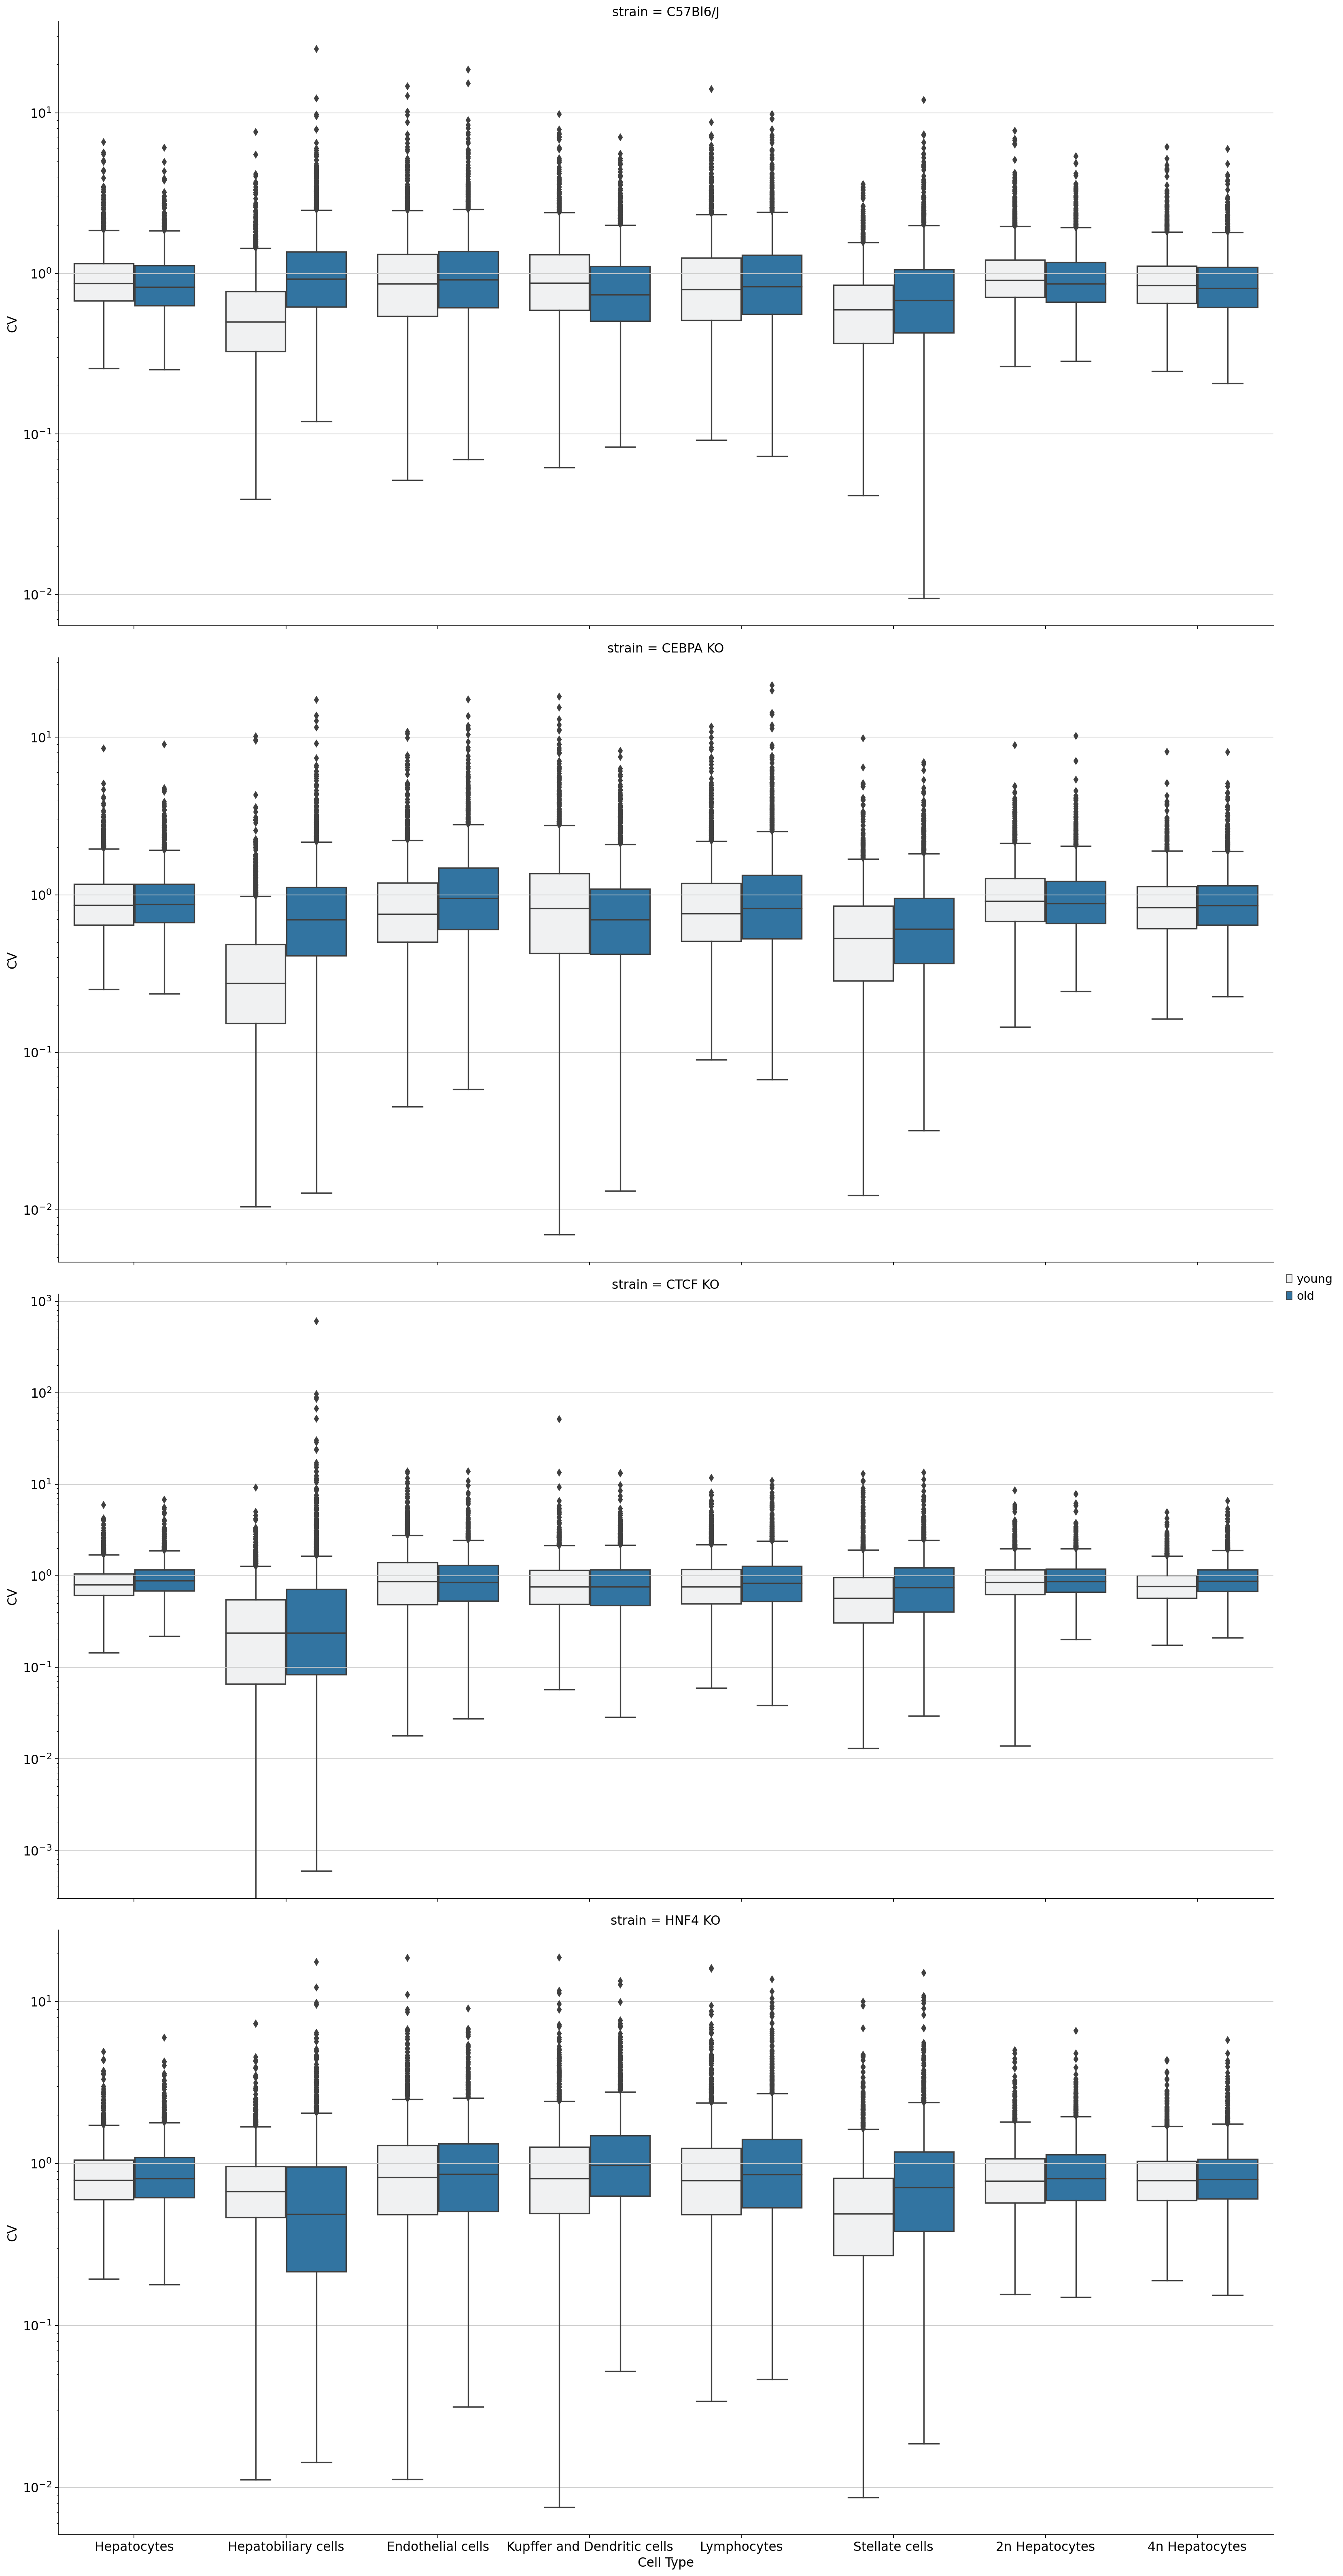

In [117]:
g = sns.FacetGrid(data=tmp_var, row='strain', sharey=False, aspect=2, height=10)
g.map(sns.boxplot, 'cell_type', 'value', 'age', 
      hue_order=['young', 'old'],
      order= ['Hepatocytes','Hepatobiliary cells',
       'Endothelial cells',
       'Kupffer and Dendritic cells', 'Lymphocytes',
              'Stellate cells', 
              '2n Hepatocytes', '4n Hepatocytes'])


for idx in range(4):
    g.fig.get_axes()[idx].set_yscale('log')
    g.fig.get_axes()[idx].set_ylabel('CV')
    
    #g.fig.get_axes()[idx].set_yticks(np.arange(-3, 2))
    #g.fig.get_axes()[idx].set_yticklabels(10.0**np.arange(-3, 2))
    #g.fig.get_axes()[idx].set_ylim([1e-5, 2e1])
g.fig.get_axes()[3].set_xlabel('Cell Type')
g.add_legend()
plt.savefig('./figures/'+today +'_cv_mean025_all.pdf', bbox_inches='tight')

Log-scale CV values for visualisation.

In [118]:
tmp_var2 = tmp_var.copy()
tmp_var2['value'] = np.log10(tmp_var2['value'])

/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Create a boxplot from the analysis.

/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


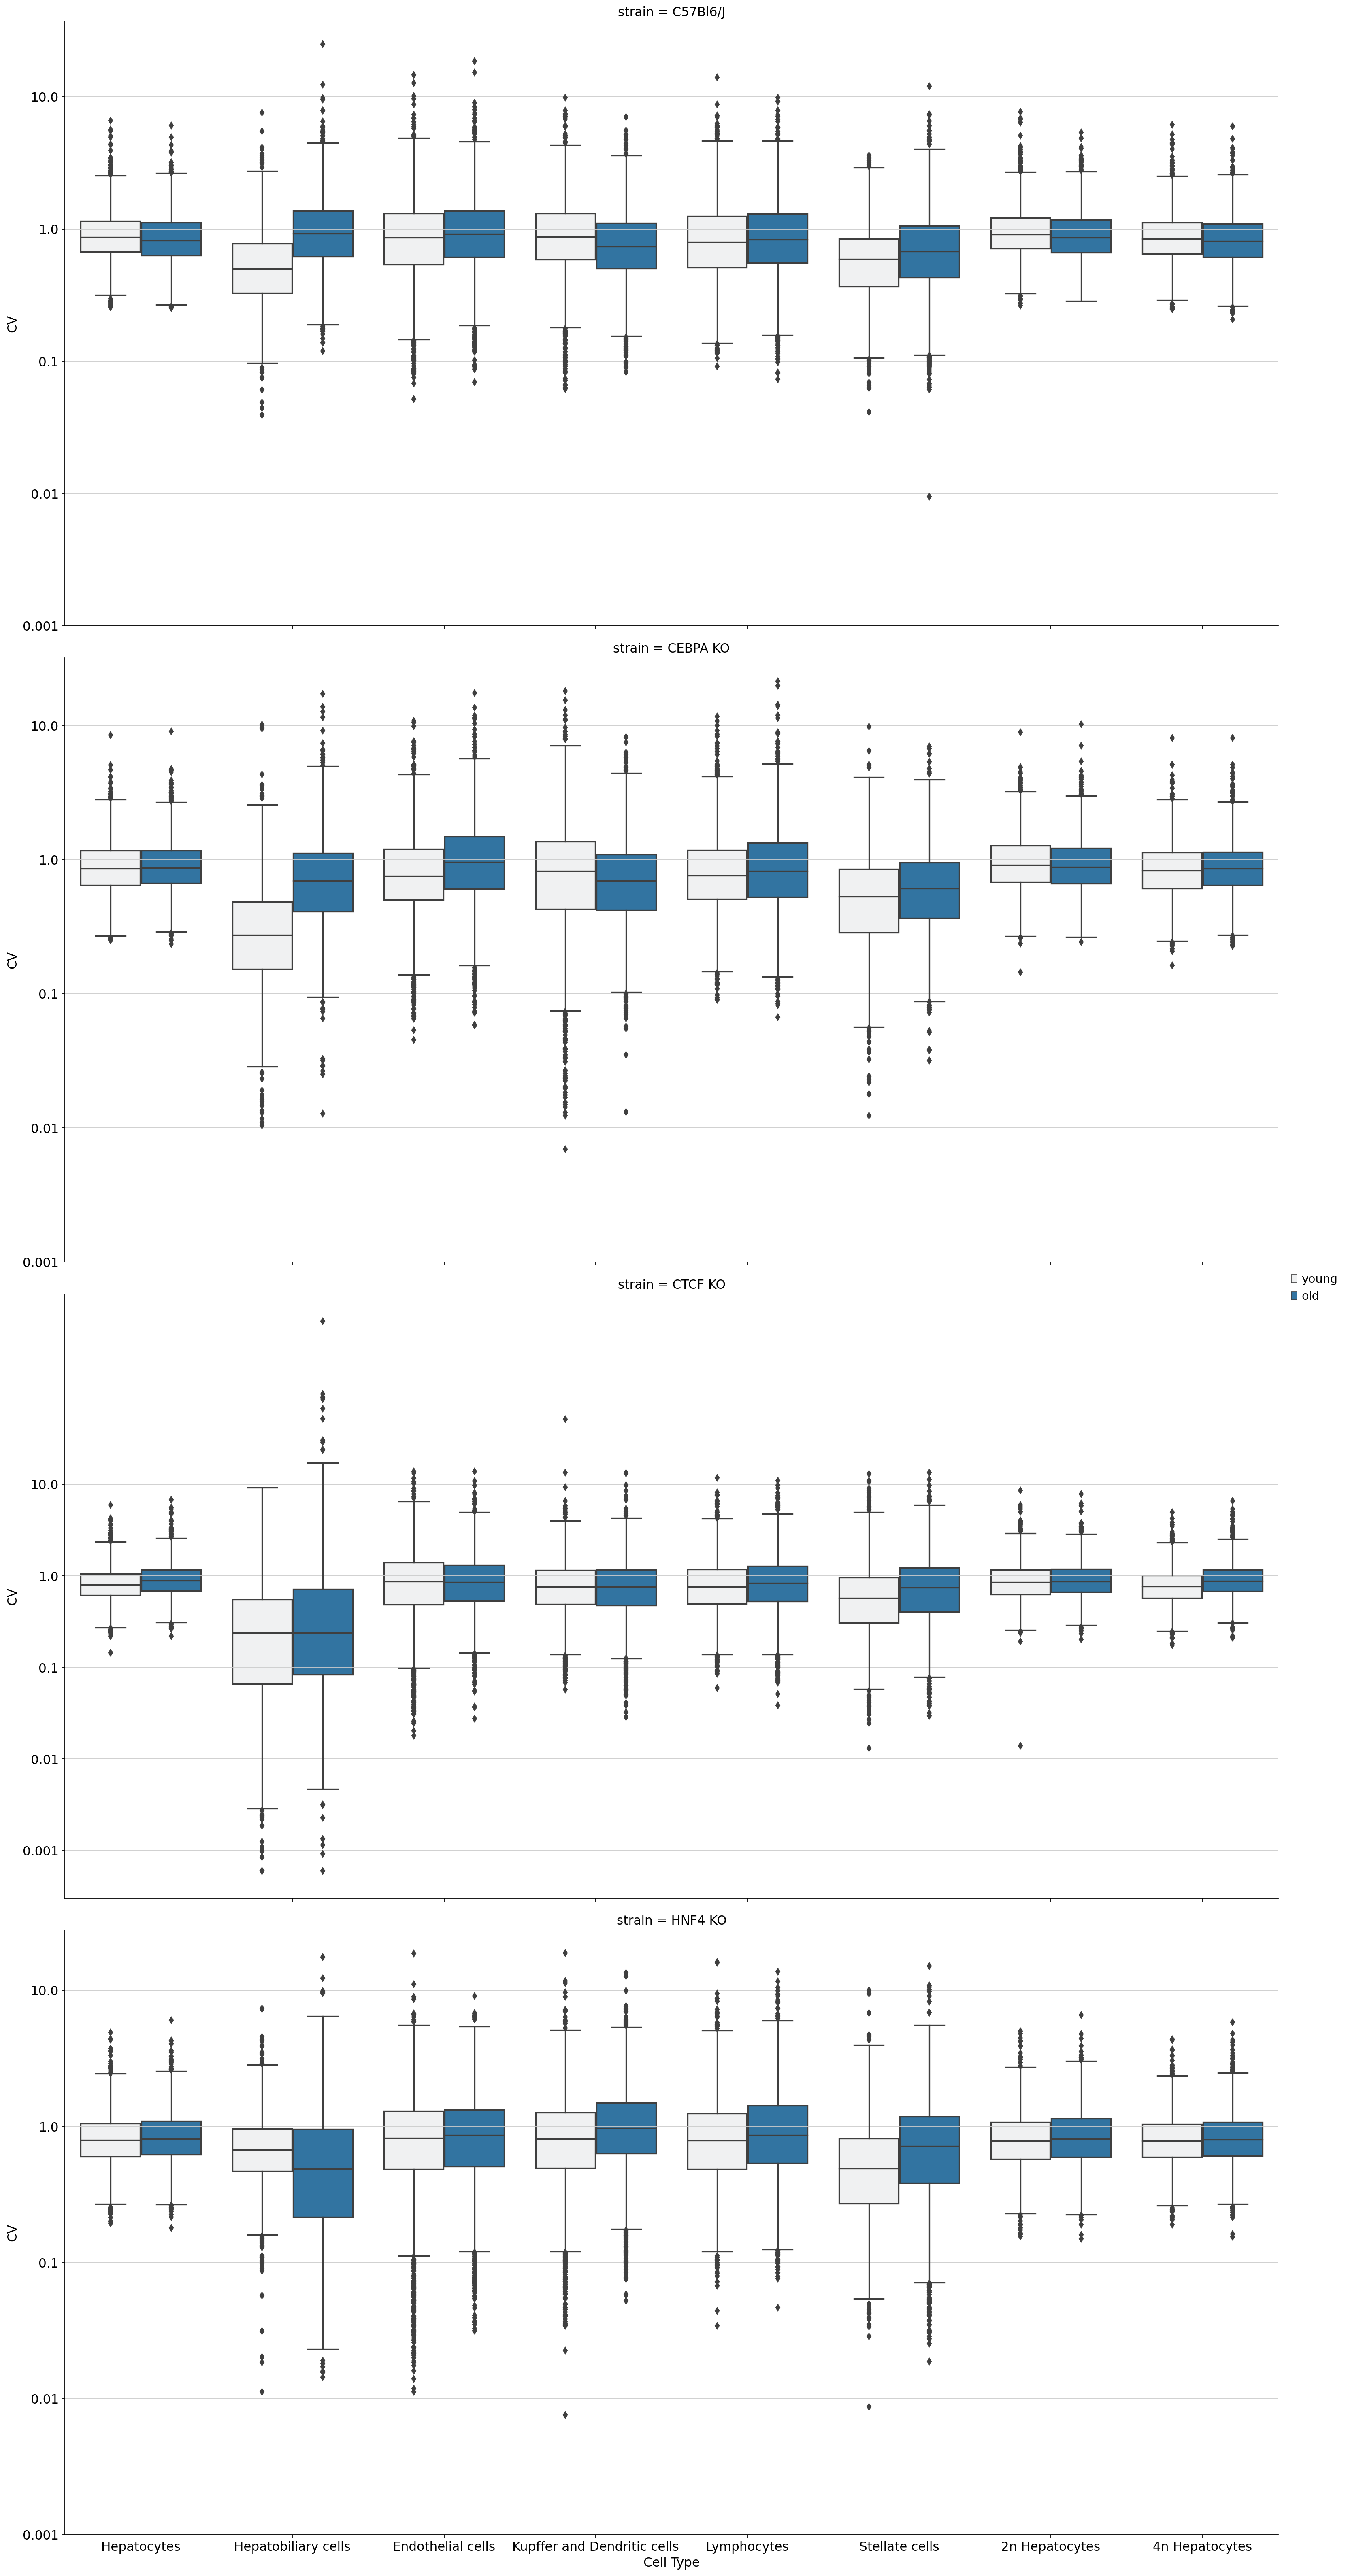

In [119]:
g = sns.FacetGrid(data=tmp_var2, row='strain', sharey=False, aspect=2, height=10)
g.map(sns.boxplot, 'cell_type', 'value', 'age')


for idx in range(4):
  #  g.fig.get_axes()[idx].set_yscale('log')
    g.fig.get_axes()[idx].set_ylabel('CV')
    
    g.fig.get_axes()[idx].set_yticks(np.arange(-3, 2))
    g.fig.get_axes()[idx].set_yticklabels(10.0**np.arange(-3, 2))
    #g.fig.get_axes()[idx].set_ylim([1e-5, 2e1])
g.fig.get_axes()[3].set_xlabel('Cell Type')
g.add_legend()
plt.savefig('./figures/'+today+'_cv_mean025_all2.pdf', bbox_inches='tight')

In [120]:
tmp_var_hep = tmp_var[np.in1d(tmp_var['cell_type'], ['2n Hepatocytes', '4n Hepatocytes'])]
tmp_var_hep2 = tmp_var_hep
tmp_var_hep2.loc[:,'value'] = np.log10(tmp_var_hep2['value'])

/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


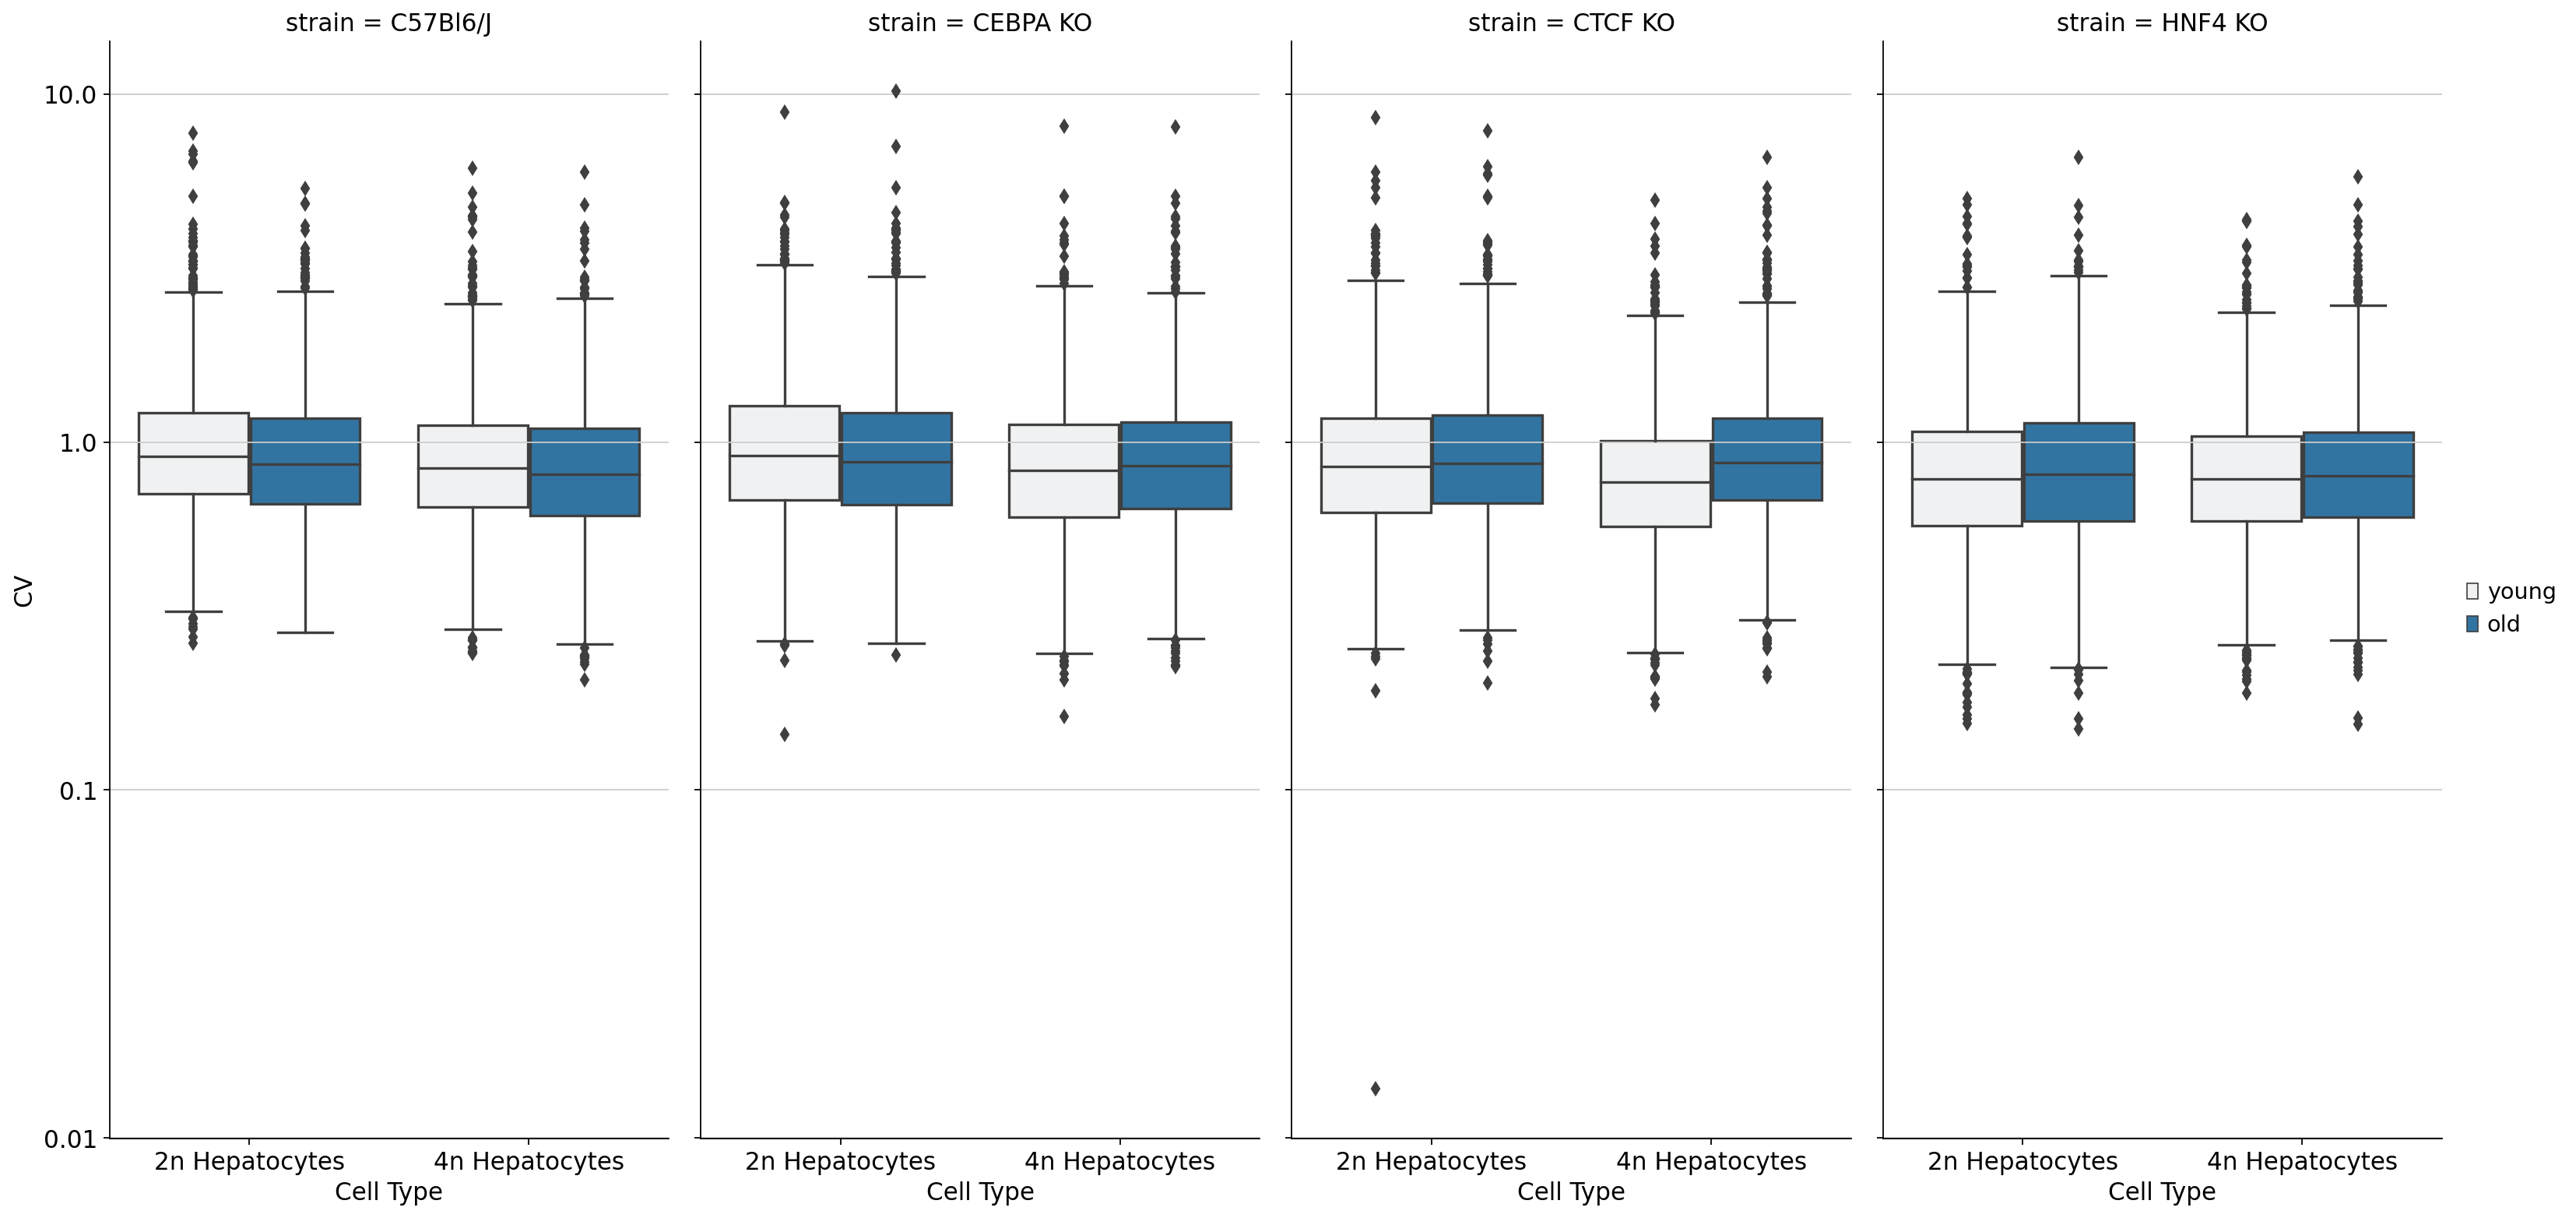

In [121]:
g = sns.FacetGrid(data=tmp_var_hep2, col='strain', sharey=True, aspect=0.5, height=10)
g.map(sns.boxplot, 'cell_type', 'value', 'age')
g.fig.get_axes()[0].set_ylabel('CV')

for idx in range(4):
    
    g.fig.get_axes()[idx].set_xlabel('Cell Type')
    g.fig.get_axes()[idx].set_yticks(np.arange(-2, 2))
    g.fig.get_axes()[idx].set_yticklabels(10.0**np.arange(-2, 2))
g.add_legend()
plt.savefig('./figures/'+today+'_cv_mean025_hepatocytes.pdf', bbox_inches='tight')

## Test for changes in variability

We aim to investigate whether the variability changes across age groups. For this purpose, we use a Wilcoxon-Ranksum-test. We perform a one-sided test with the alternative hypotheses "x greater than y" and "x less than y", where x represents the young samples and y represents the old samples.

In [50]:
df_CV.head()

,ENSMUSG00000000085,ENSMUSG00000000184,ENSMUSG00000000301,ENSMUSG00000000325,ENSMUSG00000000326,ENSMUSG00000000346,ENSMUSG00000000355,ENSMUSG00000000409,ENSMUSG00000000439,ENSMUSG00000000555,...,ENSMUSG00000116234,ENSMUSG00000116354,ENSMUSG00000116615,ENSMUSG00000116673,ENSMUSG00000116676,ENSMUSG00000116802,ENSMUSG00000116916,age,cell_type,strain
CV_young_Hepatocytes_C57Bl6/J,1.761054,1.079513,1.051382,0.930524,1.135504,0.902635,0.696960,1.072584,0.925386,1.109351,...,0.824333,1.478827,1.726997,0.653593,1.512654,0.584498,0.833358,young,Hepatocytes,C57Bl6/J
CV_old_Hepatocytes_C57Bl6/J,1.582876,1.211615,1.137545,0.853680,0.949070,0.844707,0.601430,0.871125,0.820233,0.822765,...,0.762276,1.446492,1.248886,0.616149,1.123094,0.601655,0.795614,old,Hepatocytes,C57Bl6/J
CV_young_Hepatobiliary cells_C57Bl6/J,1.015072,0.752833,0.641430,0.470495,0.897257,0.608980,0.378123,1.039893,0.399206,0.371476,...,0.185473,0.423966,0.607052,0.271431,0.807100,0.438635,0.399771,young,Hepatobiliary cells,C57Bl6/J
CV_old_Hepatobiliary cells_C57Bl6/J,3.284709,4.069301,0.997231,2.000319,1.813675,1.522292,0.592086,1.421334,0.759319,0.499181,...,0.730465,0.686186,1.574791,0.826272,2.573765,0.785858,2.114546,old,Hepatobiliary cells,C57Bl6/J
CV_young_Endothelial cells_C57Bl6/J,2.271935,2.532150,0.346322,1.992370,1.726745,0.597319,0.286315,1.514059,0.279015,0.908413,...,1.837670,0.248816,2.065591,1.049580,3.018239,0.945598,1.957213,young,Endothelial cells,C57Bl6/J


In [51]:
from scipy.stats import wilcoxon

['Hepatocytes',
 'Hepatobiliary cells',
 'Endothelial cells',
 'Kupffer and Dendritic cells',
 'Lymphocytes',
 'Stellate cells',
 '2n Hepatocytes',
 '4n Hepatocytes']

In [94]:
wilcoxon_test = dict()
cell_type_key_list = list(cell_type_keys) + list(cell_type_keys2)

for strain_key in strain_keys:
    strain_sel = df_CV['strain']==strain_key
    #iterate over cell types
    for cell_type_key in cell_type_key_list:
        ct_sel = df_CV['cell_type']==cell_type_key
        df_test = df_CV.iloc[strain_sel.values & ct_sel.values,]
        #sanity check that the first row in the df_test data frame represents the young samples
        print(df_test.iloc[:,-3])
        #remove metadata before testing
        df_test = df_test.iloc[:,:-3]
        _, wilcoxon_test[cell_type_key+ '_' + strain_key + '_greater'] = wilcoxon(x=df_test.iloc[0,], 
                                                                  y=df_test.iloc[1,],
                                                                  alternative = 'greater'
                                                                 )
        _, wilcoxon_test[cell_type_key+ '_' + strain_key + '_less'] = wilcoxon(x=df_test.iloc[0,], 
                                                                  y=df_test.iloc[1,],
                                                                  alternative = 'less'
                                                                 )

CV_young_Hepatocytes_C57Bl6/J    young
CV_old_Hepatocytes_C57Bl6/J        old
Name: age, dtype: object
CV_young_Hepatobiliary cells_C57Bl6/J    young
CV_old_Hepatobiliary cells_C57Bl6/J        old
Name: age, dtype: object
CV_young_Endothelial cells_C57Bl6/J    young
CV_old_Endothelial cells_C57Bl6/J        old
Name: age, dtype: object
CV_young_Kupffer and Dendritic cells_C57Bl6/J    young
CV_old_Kupffer and Dendritic cells_C57Bl6/J        old
Name: age, dtype: object
CV_young_Lymphocytes_C57Bl6/J    young
CV_old_Lymphocytes_C57Bl6/J        old
Name: age, dtype: object
CV_young_Stellate cells_C57Bl6/J    young
CV_old_Stellate cells_C57Bl6/J        old
Name: age, dtype: object
CV_young_2n Hepatocytes_C57Bl6/J    young
CV_old_2n Hepatocytes_C57Bl6/J        old
Name: age, dtype: object
CV_young_4n Hepatocytes_C57Bl6/J    young
CV_old_4n Hepatocytes_C57Bl6/J        old
Name: age, dtype: object
CV_young_Hepatocytes_CEBPA KO    young
CV_old_Hepatocytes_CEBPA KO        old
Name: age, dtype: ob

In [95]:
test_results = pd.Series(data = wilcoxon_test)

In [96]:
test_results.to_csv(data_dir + today + '_variability_wilcoxon_test.csv')

### Select only non-changing genes.

For the variability analysis, let us select genes whose mean expression does not change over time. Therefore, we also compute the gene mean expression per cell type (hepatocytes only), strain and age group (and ploidy).  

To assess whether a gene has not changed in mean expression, we use the results of the differential expression tests, where we used the scanpy DE test. 

Load test results first and focus on the results from testing young vs old Hepatocytes.

In [122]:
files = os.listdir(data_dir)

In [123]:
date = '210906' #date when we performed the DE tests

In [135]:
files_csv = [fileID for fileID in files if (fileID.startswith('DE_test_young_vs_old_')) and fileID.count(date)]

In [136]:
files_csv

['DE_test_young_vs_old_CTCF KO_2n Hepatocytes_gene_expression_210906_filter25.csv',
 'DE_test_young_vs_old_C57Bl6J_2n Hepatocytes_gene_expression_210906_filter25.csv',
 'DE_test_young_vs_old_CEBPA KO_2n Hepatocytes_gene_expression_210906_filter25.csv',
 'DE_test_young_vs_old_HNF4 KO_4n Hepatocytes_gene_expression_210906_filter25.csv',
 'DE_test_young_vs_old_HNF4 KO_2n Hepatocytes_gene_expression_210906_filter25.csv',
 'DE_test_young_vs_old_CTCF KO_4n Hepatocytes_gene_expression_210906_filter25.csv',
 'DE_test_young_vs_old_C57Bl6J_4n Hepatocytes_gene_expression_210906_filter25.csv',
 'DE_test_young_vs_old_CEBPA KO_4n Hepatocytes_gene_expression_210906_filter25.csv']

In [137]:
result_table = dict()
for fileID in files_csv:
    tmp_table = pd.read_csv(data_dir + fileID, index_col = 0)
    result_table[fileID] =  tmp_table

In [138]:
result_table.keys()

dict_keys(['DE_test_young_vs_old_CTCF KO_2n Hepatocytes_gene_expression_210906_filter25.csv', 'DE_test_young_vs_old_C57Bl6J_2n Hepatocytes_gene_expression_210906_filter25.csv', 'DE_test_young_vs_old_CEBPA KO_2n Hepatocytes_gene_expression_210906_filter25.csv', 'DE_test_young_vs_old_HNF4 KO_4n Hepatocytes_gene_expression_210906_filter25.csv', 'DE_test_young_vs_old_HNF4 KO_2n Hepatocytes_gene_expression_210906_filter25.csv', 'DE_test_young_vs_old_CTCF KO_4n Hepatocytes_gene_expression_210906_filter25.csv', 'DE_test_young_vs_old_C57Bl6J_4n Hepatocytes_gene_expression_210906_filter25.csv', 'DE_test_young_vs_old_CEBPA KO_4n Hepatocytes_gene_expression_210906_filter25.csv'])

In [139]:
result_table['DE_test_young_vs_old_C57Bl6J_2n Hepatocytes_gene_expression_210906_filter25.csv'].head()

,gene_name,mean,old_mean,old_n_cells,old_log2FC,old_pvals_adj,young_mean,young_n_cells,young_log2FC,young_pvals_adj,changes_hep
ENSMUSG00000000001,Gnai3,0.052044,0.053433,66,-0.455202,0.619638,0.081260,129,0.455202,0.619638,none
ENSMUSG00000000028,Cdc45,0.035278,0.087864,8,-0.369145,0.875662,0.213395,25,0.369145,0.875662,none
ENSMUSG00000000037,Scml2,0.003910,0.001577,3,-2.015195,0.239376,0.006631,16,2.015195,0.239376,none
ENSMUSG00000000049,Apoh,0.150591,0.353321,125,0.784300,0.062652,0.215671,174,-0.784300,0.062652,none
ENSMUSG00000000056,Narf,0.164064,0.721569,25,-0.278619,0.792503,1.822104,50,0.278619,0.792503,none


For every strain, take only the subset of gene that is unchanged in both 2n and 4n hepatocytes.

In [115]:
tmp_var = df_CV.melt(id_vars=['age', 'strain', 'cell_type'])

In [158]:
tmp_var_selected = list()
for strain_key in strain_keys:
    print('Select unchanged genes in ' + strain_key)
    sel = np.logical_and(result_table['DE_test_young_vs_old_'+ 
                                      strain_key.replace('/','') + 
                                      '_2n Hepatocytes_gene_expression_210906_filter25.csv']['changes_hep']=='none',
                         result_table['DE_test_young_vs_old_'+ 
                                      strain_key.replace('/','') + 
                                      '_4n Hepatocytes_gene_expression_210906_filter25.csv']['changes_hep']=='none')
    tmp = tmp_var[tmp_var.strain == strain_key].copy() 
    print(tmp.shape)
    tmp_var_selected.append(tmp[tmp.variable.isin(sel.index.values)]) 

Select unchanged genes in C57Bl6/J
(31840, 5)
Select unchanged genes in CEBPA KO
(31840, 5)
Select unchanged genes in CTCF KO
(31840, 5)
Select unchanged genes in HNF4 KO
(31840, 5)


In [163]:
tmp_var_sel = pd.concat(tmp_var_selected, ignore_index=True)

In [164]:
tmp_var_sel

,age,strain,cell_type,variable,value
0,young,C57Bl6/J,Hepatocytes,ENSMUSG00000000085,1.761054
1,old,C57Bl6/J,Hepatocytes,ENSMUSG00000000085,1.582876
2,young,C57Bl6/J,Hepatobiliary cells,ENSMUSG00000000085,1.015072
3,old,C57Bl6/J,Hepatobiliary cells,ENSMUSG00000000085,3.284709
4,young,C57Bl6/J,Endothelial cells,ENSMUSG00000000085,2.271935
...,...,...,...,...,...
127355,old,HNF4 KO,Stellate cells,ENSMUSG00000116916,1.126183
127356,young,HNF4 KO,2n Hepatocytes,ENSMUSG00000116916,0.570245
127357,old,HNF4 KO,2n Hepatocytes,ENSMUSG00000116916,0.791963
127358,young,HNF4 KO,4n Hepatocytes,ENSMUSG00000116916,0.810864


Create a boxplot from the analysis (log-scaled axis afterwards).

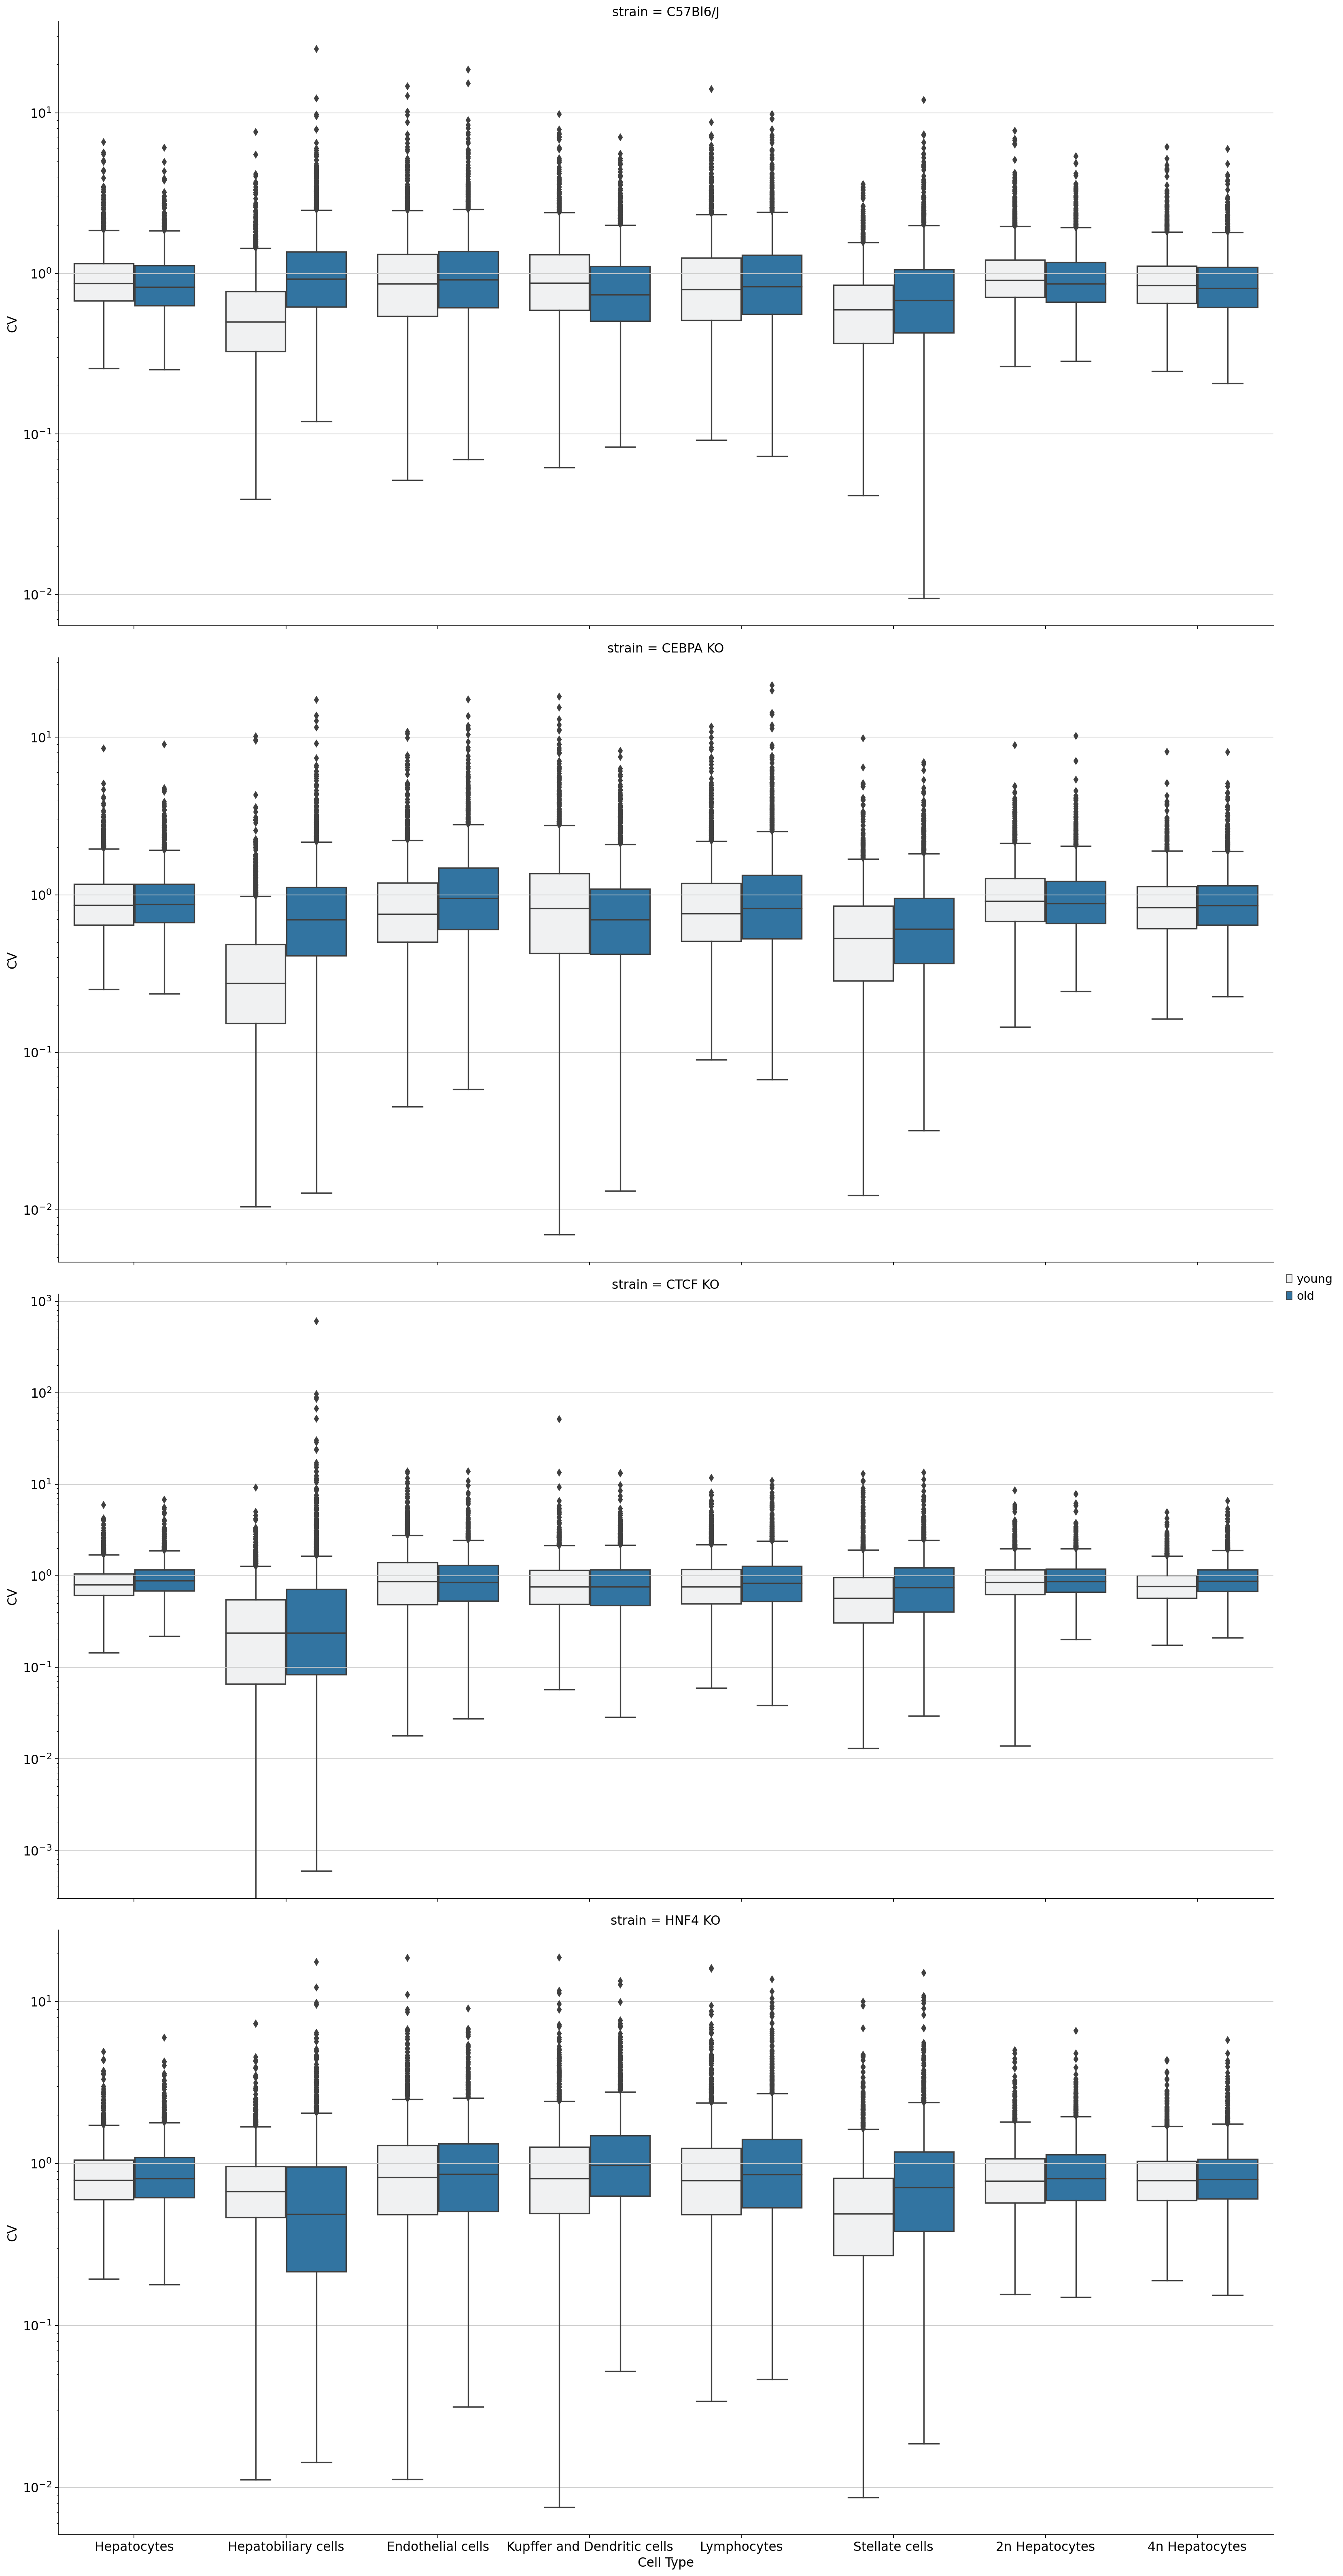

In [167]:
g = sns.FacetGrid(data=tmp_var_sel, row='strain', sharey=False, aspect=2, height=10)
g.map(sns.boxplot, 'cell_type', 'value', 'age', 
      hue_order=['young', 'old'],
      order= ['Hepatocytes','Hepatobiliary cells',
       'Endothelial cells',
       'Kupffer and Dendritic cells', 'Lymphocytes',
              'Stellate cells', 
              '2n Hepatocytes', '4n Hepatocytes'])


for idx in range(4):
    g.fig.get_axes()[idx].set_yscale('log')
    g.fig.get_axes()[idx].set_ylabel('CV')
    
    #g.fig.get_axes()[idx].set_yticks(np.arange(-3, 2))
    #g.fig.get_axes()[idx].set_yticklabels(10.0**np.arange(-3, 2))
    #g.fig.get_axes()[idx].set_ylim([1e-5, 2e1])
g.fig.get_axes()[3].set_xlabel('Cell Type')
g.add_legend()
plt.savefig('./figures/'+today +'_cv_mean025_non-changed-genes.pdf', bbox_inches='tight')

In [168]:
tmp_var2 = tmp_var_sel.copy()
tmp_var2['value'] = np.log10(tmp_var2['value'])

/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Create a boxplot from the analysis.

/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


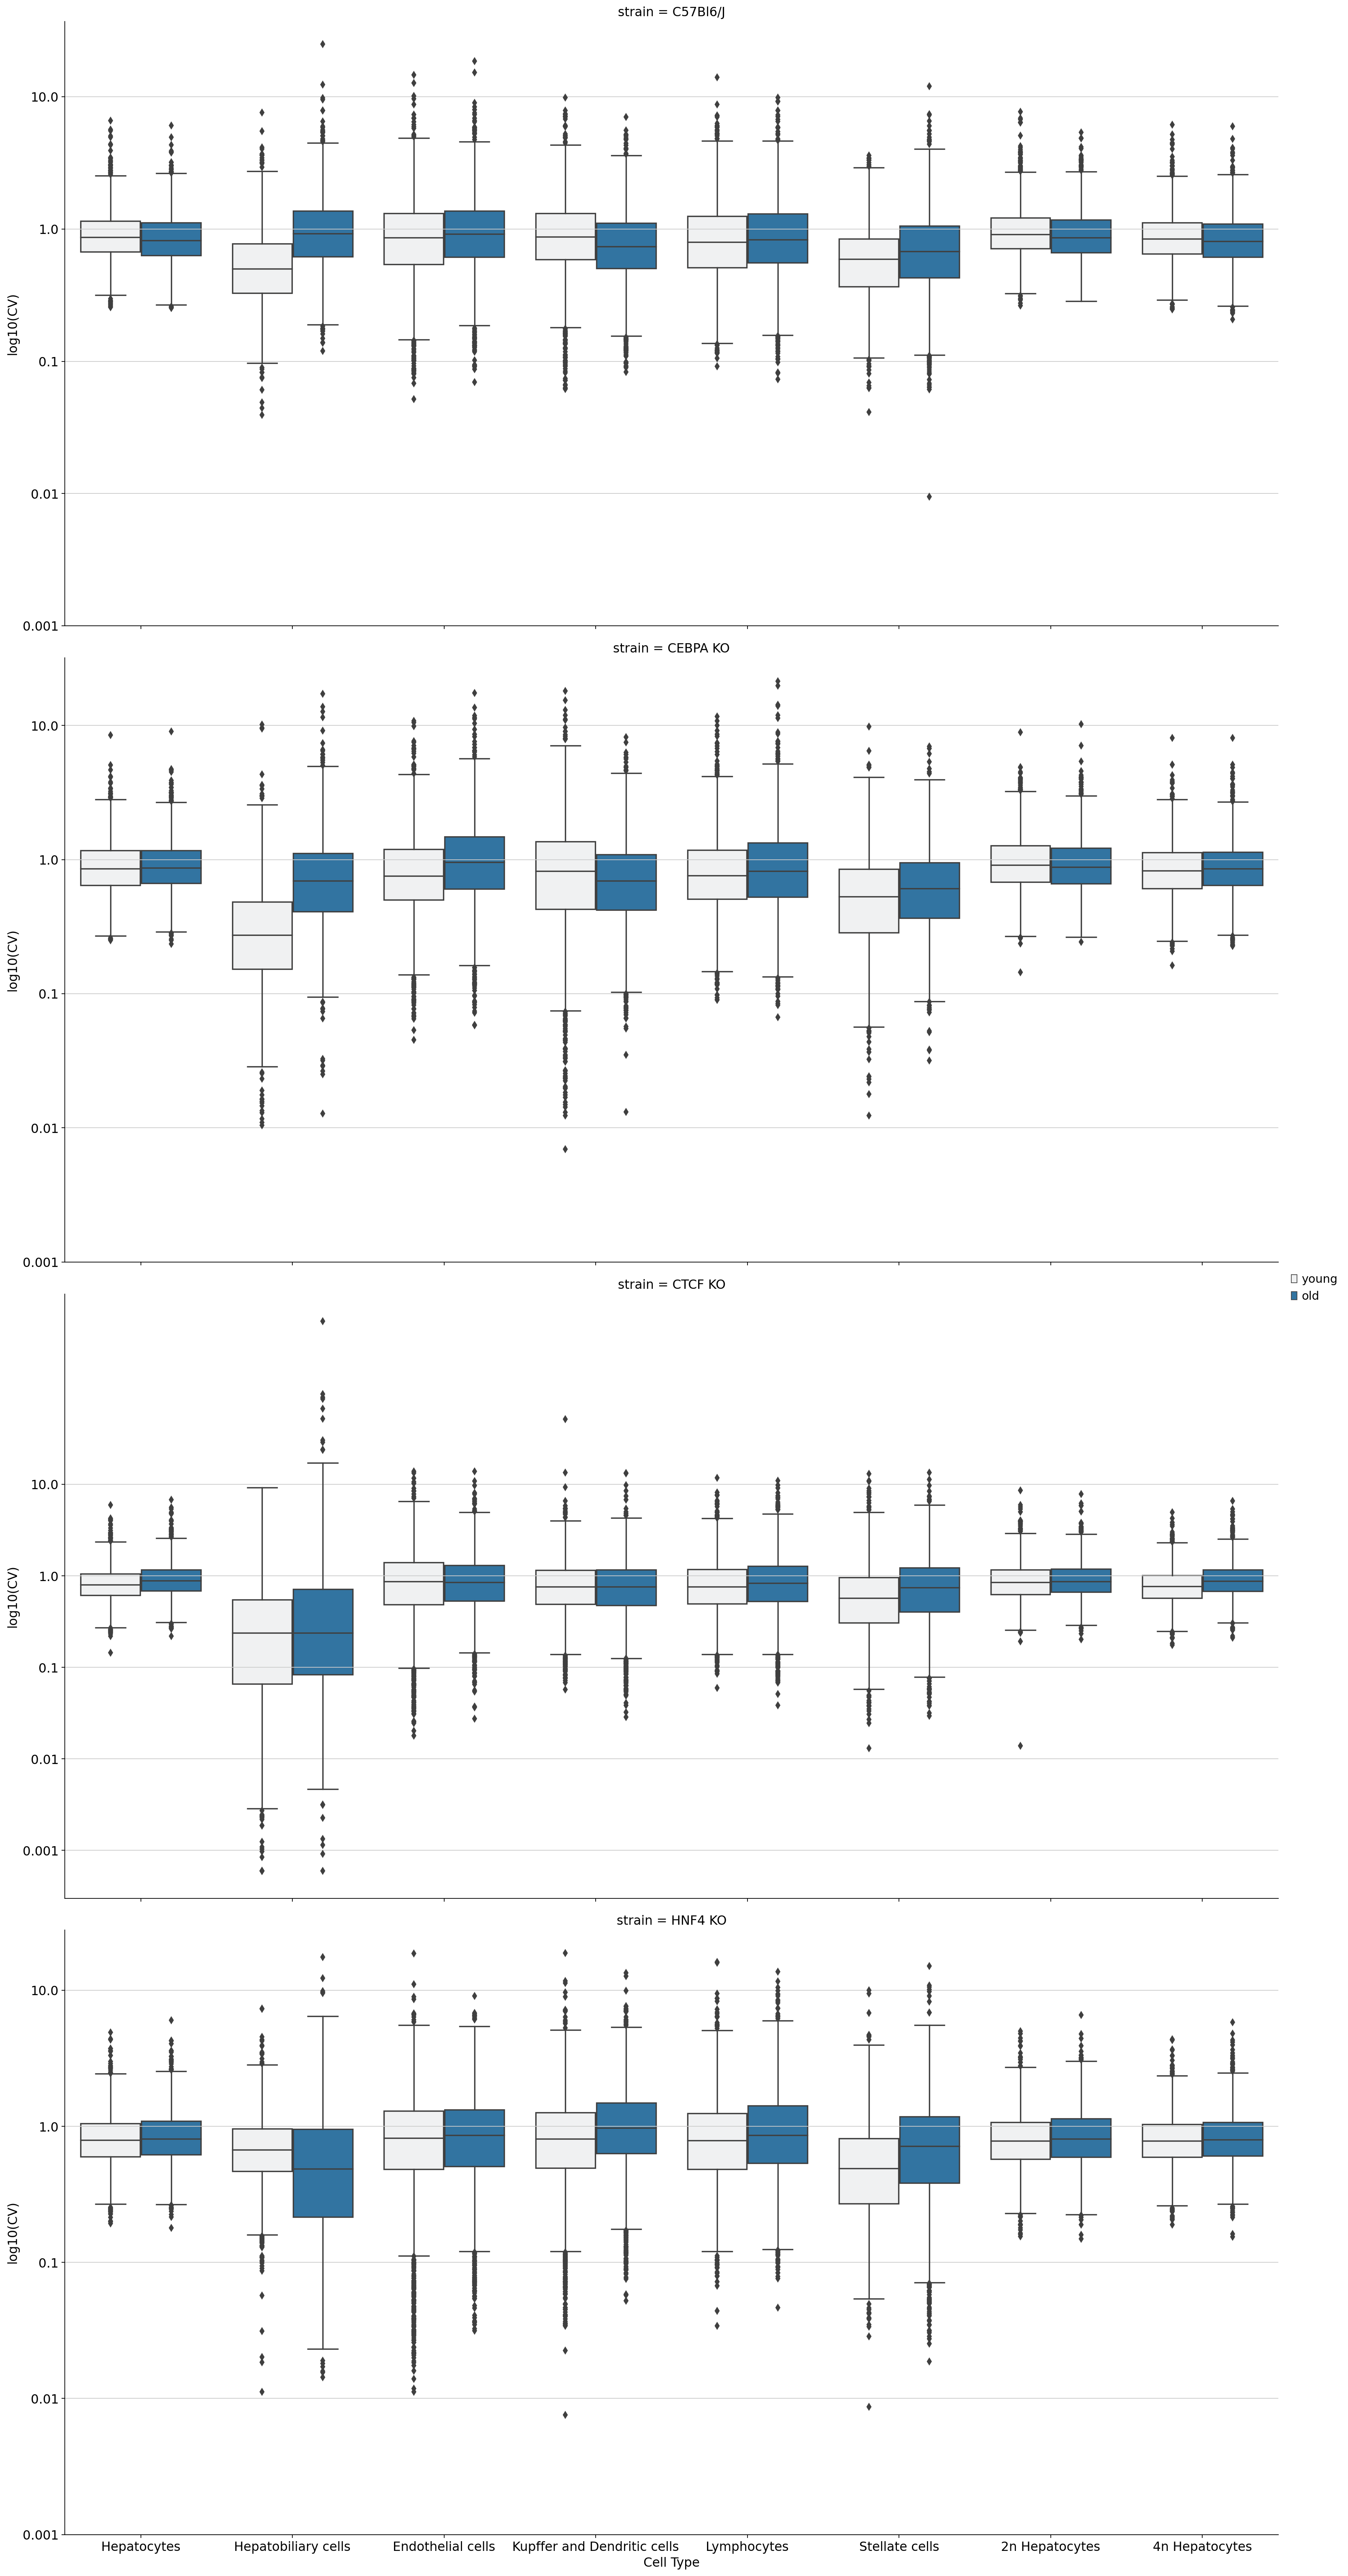

In [174]:
g = sns.FacetGrid(data=tmp_var2, row='strain', sharey=False, aspect=2, height=10)
g.map(sns.boxplot, 'cell_type', 'value', 'age')


for idx in range(4):
  #  g.fig.get_axes()[idx].set_yscale('log')
    g.fig.get_axes()[idx].set_ylabel('log10(CV)')
    
    g.fig.get_axes()[idx].set_yticks(np.arange(-3, 2))
    g.fig.get_axes()[idx].set_yticklabels(10.0**np.arange(-3, 2))
    #g.fig.get_axes()[idx].set_ylim([1e-5, 2e1])
g.fig.get_axes()[3].set_xlabel('Cell Type')
g.add_legend()
plt.savefig('./figures/'+today+'_cv_mean025_all2_non-changed-genes.pdf', bbox_inches='tight')

In [170]:
tmp_var_hep = tmp_var_sel[np.in1d(tmp_var_sel['cell_type'], ['2n Hepatocytes', '4n Hepatocytes'])]
tmp_var_hep2 = tmp_var_hep
tmp_var_hep2.loc[:,'value'] = np.log10(tmp_var_hep2['value'])

/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/icb/maren.buettner/anaconda3/envs/scanpy1-6/lib/python3.8/site-packages/seaborn/axisgrid.py:650: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


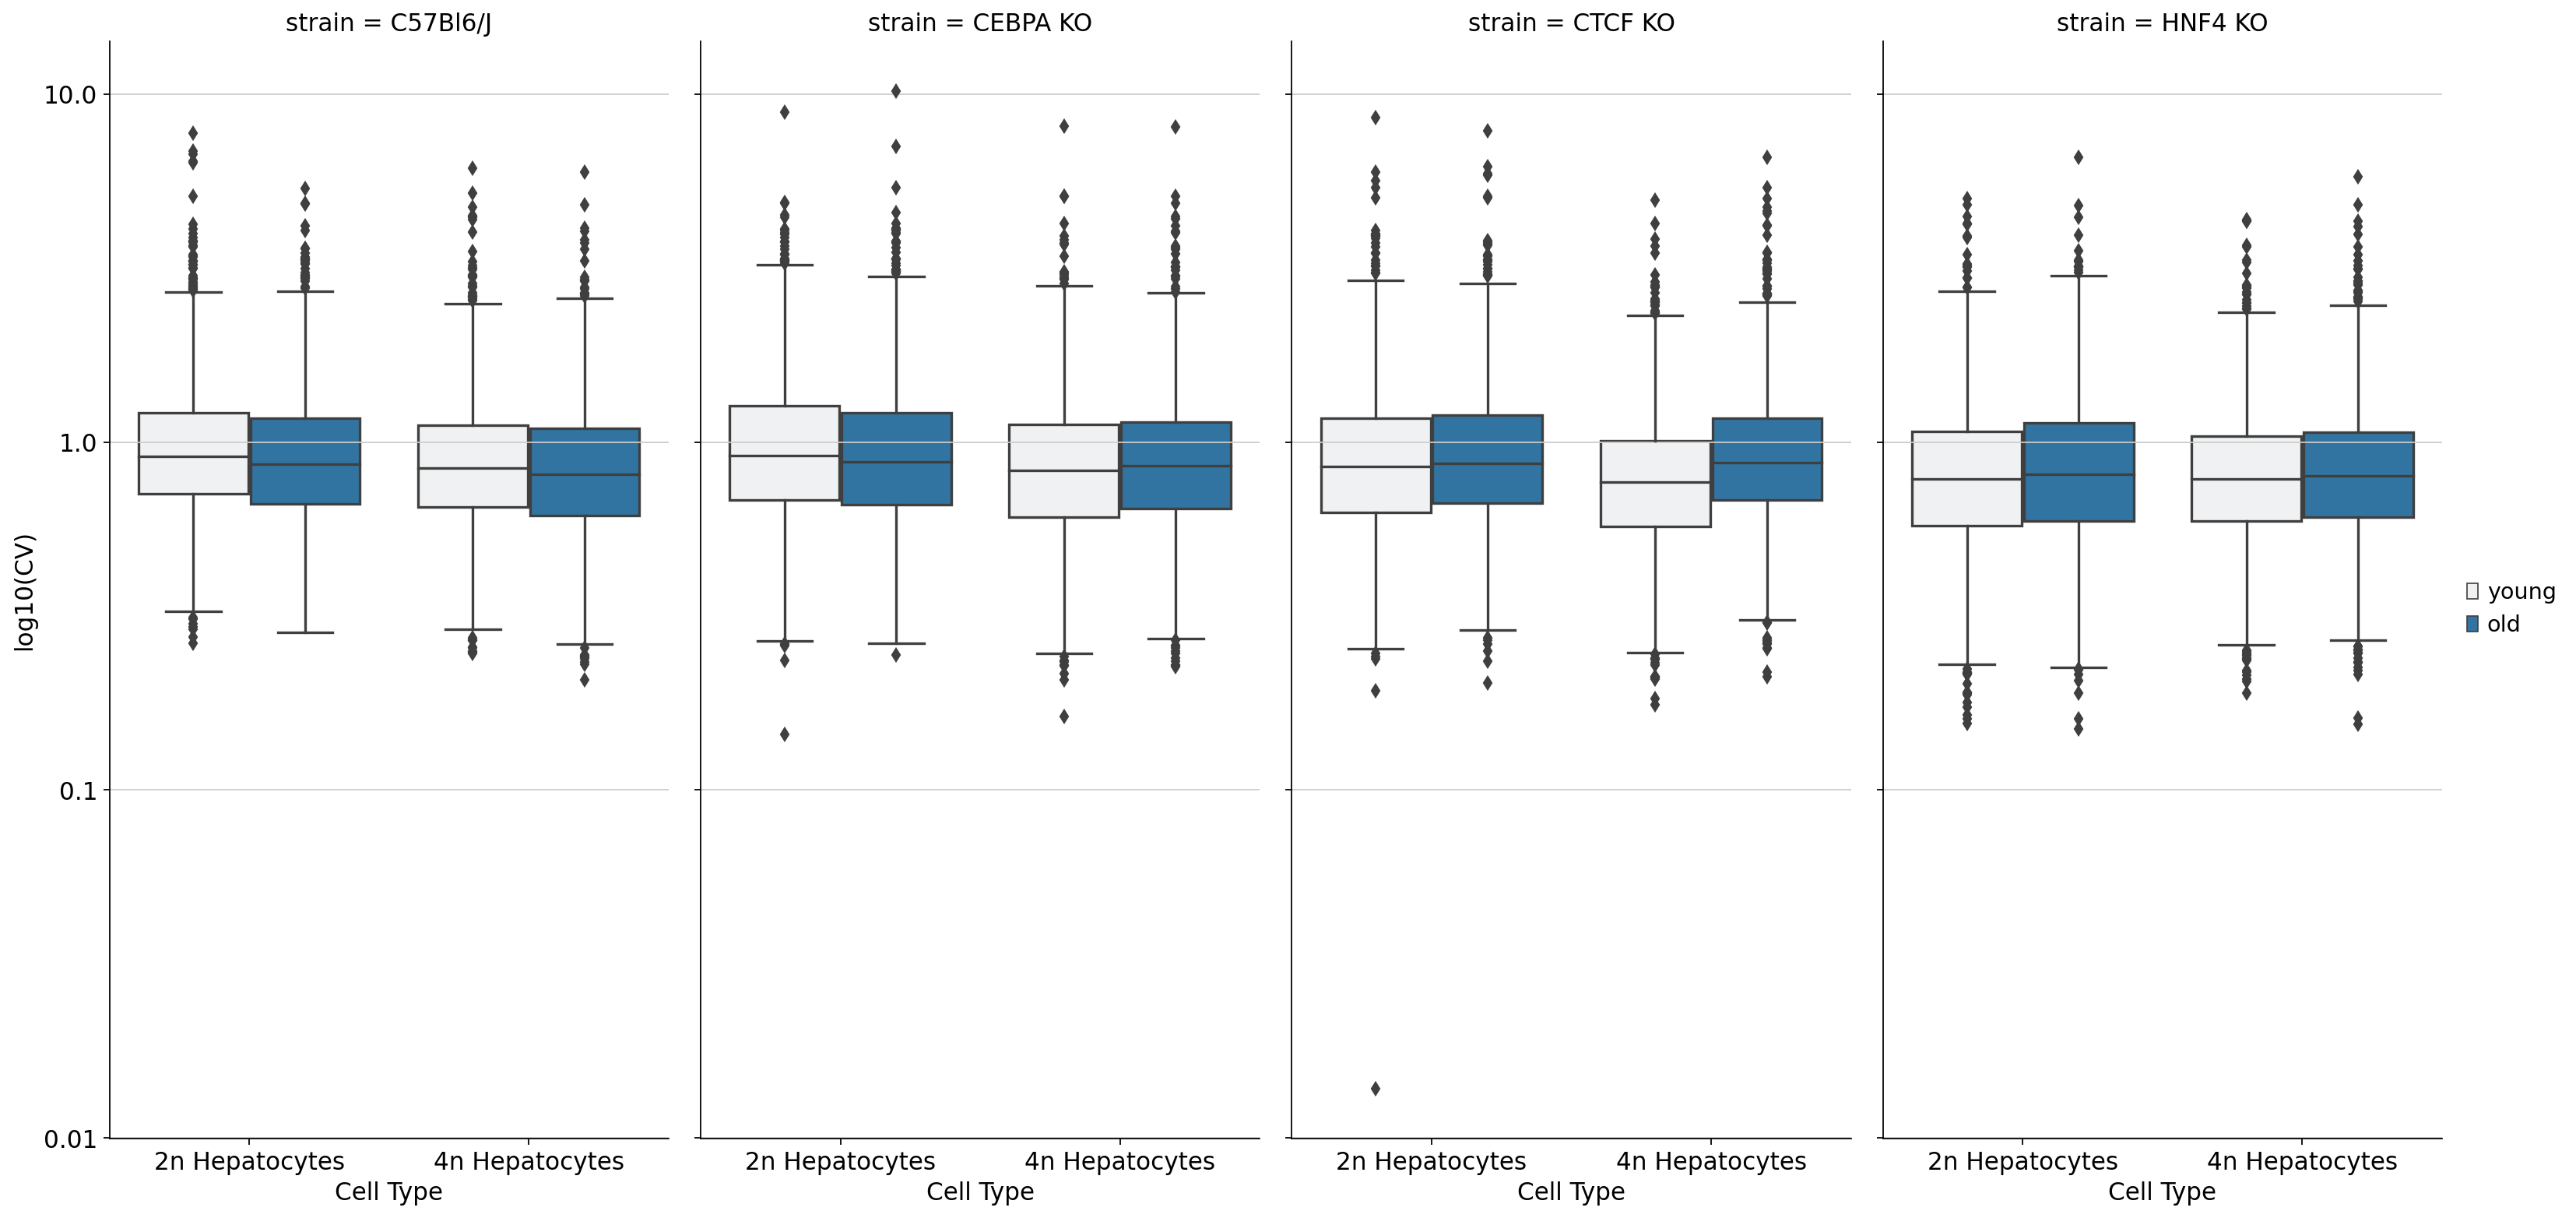

In [175]:
g = sns.FacetGrid(data=tmp_var_hep2, col='strain', sharey=True, aspect=0.5, height=10)
g.map(sns.boxplot, 'cell_type', 'value', 'age')
g.fig.get_axes()[0].set_ylabel('log10(CV)')

for idx in range(4):
    
    g.fig.get_axes()[idx].set_xlabel('Cell Type')
    g.fig.get_axes()[idx].set_yticks(np.arange(-2, 2))
    g.fig.get_axes()[idx].set_yticklabels(10.0**np.arange(-2, 2))
g.add_legend()
plt.savefig('./figures/'+today+'_cv_mean025_hepatocytes-non-changing-genes.pdf', bbox_inches='tight')